# Figure 1: singletons

In [1]:

# imported packages
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as plticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import cm
import scipy.special
import scipy.integrate as it
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.stats import kde
import copy
import glob, os
import re
# from sklearn import datasets, linear_model
import pandas as pd
from decimal import *
from operator import itemgetter    
from collections import OrderedDict
import timeit
import time 
import csv
import seaborn as sns 
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
from matplotlib.backends.backend_pdf import PdfPages
import statsmodels.api as sm
import plotly.express as px
import kaleido

# my functions is a custom script I wrote to manage dataframes
from myfunctions import transform_format 
from myfunctions import find_best_score_for_present_var
from myfunctions import find_best_score


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# set up plotting parameters 
axisfont=11
titlefont=20
subtitlefont = 15
axislabelfont=12
legendfont = 11
tpfont = 12
plt.rcParams.update({'font.sans-serif':'Arial'})

In [4]:
# get current date 
timestr = time.strftime("%Y%m%d") 

In [3]:
# do not print warnings (can be run if you don't want warnings to be printed)
import warnings
warnings.filterwarnings("ignore")

## Load the dataset with CH cases and all screened datasets

In [5]:

# Import all the data (all calls: include singletons and higher read numbers, for all changes at a position affected in CH)

# path to ukb files from Hamish 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls_annotated'  

# get all files in the folder 
files = glob.glob(os.path.join(folder_path, '*.txt'))  
# print('Files examined are:', files)

# initialize an empty dictionary 
dataframes = {}

# iterate through the CSV files and read each one with pandas
for csv_file in files:
    
    df = pd.read_csv(csv_file, sep = '\t')
    dataframes[csv_file] = df

# extract dataframes 
for file_name, df in dataframes.items():
    
    # construct variable names dynamically based on file names
    variable_name = file_name.split('/')[8].split('.')[0] + '_data'  # Removing the file extension
    print('Examined file:', variable_name)
    
    df['batch'] = variable_name # add column to indicate source 
    globals()[variable_name] = df  # assign df to a variable with the file name

# concat all into one df
dfs_to_concat = [v for k, v in globals().items() if k.endswith('_data') and isinstance(v, pd.DataFrame)]

# combine all dfs into one 
batch_all = pd.concat(dfs_to_concat, ignore_index=True)
batch_all = batch_all.dropna(subset=['batch']) # remove rows which are read incorrectly (w/o batch number)

print('Number of samples with variants examined:', batch_all.shape[0])

Examined file: batch_21_annotated_data
Examined file: batch_18_annotated_data
Examined file: batch_15_annotated_data
Examined file: batch_11_annotated_data
Examined file: batch_16_annotated_data
Examined file: batch_12_annotated_data
Examined file: batch_13_annotated_data
Examined file: batch_17_annotated_data
Examined file: batch_14_annotated_data
Examined file: batch_19_annotated_data
Examined file: batch_20_annotated_data
Number of samples with variants examined: 76718


In [6]:

# change numerical variables to integers
batch_all['end_position'] = batch_all['end_position'].astype(int)
batch_all['position'] = batch_all['position'].astype(int)
batch_all['sample_ID'] = batch_all['sample_ID'].astype(int)

# view the data
batch_all.head(n = 5)

,sample_ID,chromosome,position,end_position,ref,alt,depth,var_depth,VAF,variant_type,...,EXON,GIVEN_REF,IMPACT,INTRON,STRAND,SYMBOL,SYMBOL_SOURCE,USED_REF,VARIANT_CLASS,batch
0,2100020,chr17,7674230,7674230,C,A,32,1,0.031250,SNV,...,7/11,C,MODERATE,-,-1.0,TP53,EntrezGene,C,SNV,batch_21_annotated_data
1,2100020,chr17,7675088,7675088,C,T,54,1,0.018519,SNV,...,5/11,C,MODERATE,-,-1.0,TP53,EntrezGene,C,SNV,batch_21_annotated_data
2,2100033,chr2,25234307,25234307,G,T,85,1,0.011765,SNV,...,23/23,G,MODERATE,-,-1.0,DNMT3A,EntrezGene,G,SNV,batch_21_annotated_data
3,2100071,chr2,25240439,25240439,G,A,92,1,0.010870,SNV,...,19/23,G,MODERATE,-,-1.0,DNMT3A,EntrezGene,G,SNV,batch_21_annotated_data
4,2100071,chr2,25240439,25240439,G,T,92,1,0.010870,SNV,...,19/23,G,LOW,-,-1.0,DNMT3A,EntrezGene,G,SNV,batch_21_annotated_data


In [23]:

# Import indexes tested in each batch 

# path to ukb files from Hamish 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls/batch_ids'  

# get all files in the folder 
files_ids = glob.glob(os.path.join(folder_path, '*.tsv'))  

# initialize an empty dictionary
indexes = {}

# Iterate through the CSV files and read each one with pandas
for file in files_ids:
    
    id = pd.read_csv(file, sep = '\t')
    id = id.rename(columns={'batch ID': 'sample_ID'})
    id['sample_ID'] = id['sample_ID'].str.split('_', n = 1).str[0]
    indexes[file] = id

for file_name, df in indexes.items():

    # construct variable names dynamically based on file names
    variable_name = file_name.split('/')[9].split('.')[0] # remove file extension
    globals()[variable_name] = df  # assign the df to a variable with the file name


In [24]:

print('The TOTAL number of individuals screened:', sum(len(values) for values in indexes.values()))

The TOTAL number of individuals screened: 454800


## Annotate the UKBB dataset with CH variants 

In [25]:

# The data that I imported is annotated but has not been filtered to only include variants that are present in CH

# prepare the dataframe for annotation
batch_all['end_position'] = batch_all['end_position'].astype(int)
batch_all['sample_ID'] = batch_all['sample_ID'].astype(int)

# subset and create new useful columns
batch_all = batch_all[['sample_ID', 'chromosome', 'end_position', 'VAF', 'var_depth', 'depth', 'Amino_acids', 'SYMBOL', 'Codons', 'batch']]
batch_all['alt'] = batch_all['Amino_acids'].str.split('/', expand = True)[1]
batch_all['ref'] = batch_all['Amino_acids'].str.split('/', expand = True)[0]

# create column with coordinates such that you can merge annotation (on genetic variant name)
batch_all['variant_coord'] = batch_all['chromosome'].astype(str) + "_" + batch_all['end_position'].astype(str) 
batch_all['variant_coord'] = batch_all['variant_coord'].astype('category')

# create column with coordinates, gene affected and specific variant 
batch_all['variant_coord_pos'] = batch_all['variant_coord'].astype(str) +  "_" + batch_all['SYMBOL'].astype(str) + "_" + batch_all['ref'].astype(str) + "_" + batch_all['alt'].astype(str)
batch_all['variant_coord_pos'] = batch_all['variant_coord_pos'].astype('category')

# view added columns
batch_all.head(n = 5)

# NOTE: in some cases, the amino acid column only contains a single aa value
# that does NOT indicate that there was a nonsense mutation (ie STOP codon introduced)
# STOP codons ARE indicated in the dataframe with "*"

,sample_ID,chromosome,end_position,VAF,var_depth,depth,Amino_acids,SYMBOL,Codons,batch,alt,ref,variant_coord,variant_coord_pos
0,2100020,chr17,7674230,0.031250,1,32,G/C,TP53,Ggc/Tgc,batch_21_annotated_data,C,G,chr17_7674230,chr17_7674230_TP53_G_C
1,2100020,chr17,7675088,0.018519,1,54,R/H,TP53,cGc/cAc,batch_21_annotated_data,H,R,chr17_7675088,chr17_7675088_TP53_R_H
2,2100033,chr2,25234307,0.011765,1,85,P/Q,DNMT3A,cCg/cAg,batch_21_annotated_data,Q,P,chr2_25234307,chr2_25234307_DNMT3A_P_Q
3,2100071,chr2,25240439,0.010870,1,92,R/W,DNMT3A,Cgg/Tgg,batch_21_annotated_data,W,R,chr2_25240439,chr2_25240439_DNMT3A_R_W
4,2100071,chr2,25240439,0.010870,1,92,R,DNMT3A,Cgg/Agg,batch_21_annotated_data,None,R,chr2_25240439,chr2_25240439_DNMT3A_R_None


In [26]:

# import coordinate data (df created manually based on COSMIC)
coord_gene_var = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ch_variants_coordinates_tp53_added_nts.csv')

# create required columns
coord_gene_var['variant_coord'] = coord_gene_var['chromosome'] + "_" + coord_gene_var['end_position'].astype(str) # find cariant coordinates
coord_gene_var['SYMBOL'] = coord_gene_var['gene_var'].str.split('_').str[0] # find gene analysed
coord_gene_var['ref'] = coord_gene_var['gene_var'].str.split('_').str[1].str[0] # reference sequence variant 
coord_gene_var['alt'] = coord_gene_var['gene_var'].str.split('_').str[1].str[-1] # alternative sequence (CH / mutation) variant
coord_gene_var['variant_coord_pos'] = coord_gene_var['variant_coord'].astype(str) + "_" + coord_gene_var['SYMBOL'].astype(str) + "_" + coord_gene_var['ref'].astype(str) + "_" + coord_gene_var['alt'].astype(str) # specific mutation 

print('Number of variants which have been investigated:', len(coord_gene_var.variant_coord_pos.unique()))
print('Number of sites which have been investigated:',len(coord_gene_var.variant_coord.unique()))

Number of variants which have been investigated: 42
Number of sites which have been investigated: 36


In [12]:

# Annotation

# subset required columns
gene_vars = coord_gene_var[['variant_coord_pos', 'gene_var']]

# subset batch df to only include variants which were successfully identified 
batch_gene_vars = pd.merge(batch_all, gene_vars, on = 'variant_coord_pos', how = 'inner')
batch_gene_vars['gene_var'] = batch_gene_vars['gene_var'].astype('category')
batch_gene_vars['gene_var'].value_counts()

gene_vars_count = pd.DataFrame(batch_gene_vars['gene_var'].value_counts())
gene_vars_count['gene_var'] = gene_vars_count.index
gene_vars_count = gene_vars_count.reset_index(drop=True)
gene_vars_sorted = gene_vars_count.sort_values(by = 'count', ascending=False)

print('Number of variants identified with annotations:', gene_vars_sorted.shape[0])

# so we will have 30 variants to look at bc the rest was not mapped correctly 

print('Number of samples examined:', batch_all.shape[0])
print('Number of patients examined:', len(batch_all.sample_ID.unique()))
print('Number of samples with annotated variants:', batch_gene_vars.shape[0])
print('Number of patients with annotated variants:', len(batch_gene_vars.sample_ID.unique()))

# NOTE
# I will carry out further analysis on batch_gene_vars dataframe (= contains samples with reads with CH-specific variants)
# I am working on a df that is not filtered with respect to read number (ie retaining singletons)

Number of variants identified with annotations: 38
Number of samples examined: 76718
Number of patients examined: 52356
Number of samples with annotated variants: 40752
Number of patients with annotated variants: 33377


In [36]:

# find what CH variants have not been identified in the UKBB despite being on the list to screen 
not_in_ukbb = [item for item in coord_gene_var.gene_var.unique().tolist() if item not in gene_vars_count.gene_var.unique().tolist()]
print('CH variants not identified in the UKBB:', not_in_list2)

CH variants not identified in the UKBB: ['KIT_D816F', 'NPM1_W288fs', 'TP53_R273C', 'TP53_R273H']


# Line of evidence 1: non-CH-variant reads

In [39]:

# identify reads which do not belong to either od the CH reads 
merged = batch_all.merge(gene_vars, on = 'variant_coord_pos', how='outer', indicator=True)
batch_not_ch = merged[merged['_merge'] == 'left_only']

# change variant depth to integer value 
batch_not_ch.var_depth = batch_not_ch.var_depth.astype(int)

batch_not_ch_counts = pd.DataFrame(batch_not_ch.gene_var.value_counts())
batch_not_ch_counts['gene_var'] = batch_not_ch_counts.index
batch_not_ch_counts = batch_not_ch_counts.reset_index(drop=True)
batch_not_ch_sorted = batch_not_ch_counts.sort_values(by = 'count', ascending=False)

print('Number of variants identified with annotations:', gene_vars_sorted.shape[0])
# so we will have 30 variants to look at bc the rest was not mapped correctly 

print('Number of samples examined:', batch_all.shape[0])
print('Number of patients examined:', len(batch_all.sample_ID.unique()))
print('Number of samples with annotated variants:', batch_gene_vars.shape[0])
print('Number of samples with variants other than CH hotspots:', batch_not_ch.shape[0])



Number of variants identified with annotations: 38
Number of samples examined: 76718
Number of patients examined: 52356
Number of samples with annotated variants: 40752
Number of samples with variants other than CH hotspots: 35966


In [66]:
# create a figure to display the distirbution of 1, 2, 3, 4 or more 
not_ch_counts = pd.Series(batch_not_ch.var_depth).value_counts().reset_index()
not_ch_counts.columns = ['var_depth', 'count']
not_ch_counts = not_ch_counts.sort_values(by = 'var_depth')
not_ch_counts['nr_reads_per_sample'] = np.where(not_ch_counts.var_depth == 1, 1,
                             np.where(not_ch_counts.var_depth == 2, 2,
                             np.where(not_ch_counts.var_depth == 3, 3,
                             np.where(not_ch_counts.var_depth >= 4, '4 or more', np.nan))))
not_ch_sum_read_nr = not_ch_counts.groupby('nr_reads_per_sample')['count'].sum().reset_index()
not_ch_sum_read_nr.columns = ['nr_reads_per_sample', 'count_not_ch']

yes_ch_counts = pd.Series(batch_gene_vars.var_depth).value_counts().reset_index()
yes_ch_counts.columns = ['var_depth', 'count']
yes_ch_counts = yes_ch_counts.sort_values(by = 'var_depth')
yes_ch_counts['nr_reads_per_sample'] = np.where(yes_ch_counts.var_depth == 1, 1,
                             np.where(yes_ch_counts.var_depth == 2, 2,
                             np.where(yes_ch_counts.var_depth == 3, 3,
                             np.where(yes_ch_counts.var_depth >= 4, '4 or more', np.nan))))
yes_ch_sum_read_nr = yes_ch_counts.groupby('nr_reads_per_sample')['count'].sum().reset_index()
yes_ch_sum_read_nr.columns = ['nr_reads_per_sample', 'count_ch']

# get a dataframe for both 
sum_read_nr = pd.merge(not_ch_sum_read_nr, yes_ch_sum_read_nr, on = 'nr_reads_per_sample')
sum_read_nr_melt = pd.melt(sum_read_nr, id_vars = 'nr_reads_per_sample')
sum_read_nr_melt.variable = sum_read_nr_melt.variable.astype('category')
sum_read_nr_melt.variable = sum_read_nr_melt.variable.map({'count_not_ch': 'Other variant', 'count_ch': 'CH hotspot'})
sum_read_nr_melt

,nr_reads_per_sample,variable,value
0,1,Other variant,35392
1,2,Other variant,441
2,3,Other variant,55
3,4 or more,Other variant,78
4,1,CH hotspot,38503
5,2,CH hotspot,1129
6,3,CH hotspot,334
7,4 or more,CH hotspot,786


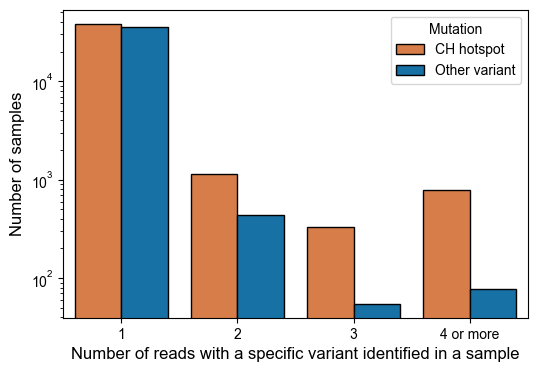

In [242]:

# plotting 
palette = ['#ee7733', '#0077bb']

plt.figure(figsize = (6, 4))
sns.barplot(data = sum_read_nr_melt, x = 'nr_reads_per_sample', y = 'value', hue = 'variable', palette = palette, edgecolor = 'black')
plt.yscale('log')

plt.xlabel('Number of reads with a specific variant identified in a sample', fontsize = 12)
plt.ylabel('Number of samples', fontsize = 12)
plt.legend(fontsize = 11)

plt.xticks(fontsize=10)  
plt.yticks(fontsize=10)

legend = plt.legend()
legend.set_title('Mutation')

plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_compare_nr_reads_ch_hotspot_other_variant.pdf', bbox_inches='tight')


# Line of evidence 2: Analysis of age dependence

In [71]:

# load the age dataset 
age_data = pd.read_csv('~/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/2022-05-20_healthy_pheno.tsv', sep = '\t')

# select columns available 
age_df = age_data[['ID_v0', 'Age.when.attended.assessment.centre_v0']] 
# rename columns
age_df.columns.values[0] = 'sample_ID'
age_df.columns.values[1] = 'age'
 
print('Number of patients for whom age data is available:', len(age_df.sample_ID.unique()))
# very possibly we are missing people who have cancer because this is just for the healthy ones 


Number of patients for whom age data is available: 459385


In [72]:

# now, we need to compare the age distribution in people who carry a variant vs people who do NOT carry a variant
# therefore, we need to first identify the IDs of everyone who was examined for the presence of variants 

# which batches have been screened for the presence of CH variants?
batch_all['batch_number'] = batch_all['batch'].apply(lambda x: [int(num) for num in re.findall(r'\d+', x)])
batch_numbers_examined = set(batch_all['batch_number'].sum()) 
print('Batches that were examined for variants:', batch_numbers_examined)


# names of all dataframes with IDs 
all_dataframes = [f'batch_{i}_ids' for i in range(11, 61)]

# initialize an empty list to store the IDs of people you screened for the presence of CH variants
selected_ids = []

# Iterate through all df name 
for df_name in all_dataframes:
    number = int(re.search(r'\d+', df_name).group())
    
    # check if number matches numbers of batches examined 
    if number in batch_numbers_examined:
        
        selected_ids.append(globals()[df_name])

# concat together 
ids_examined = pd.concat(selected_ids, ignore_index=True)

N = ids_examined.shape[0]
print('Number of samples examined for variants:', N)

Batches that were examined for variants: {11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}
Number of samples examined for variants: 99597


In [73]:

# add age data to the UKBB CH dataset 

# now, we need to combine select the patients we look and and for whom we have age
ids_examined_list = ids_examined.sample_ID.tolist()
ids_examined_list = [int(x) for x in ids_examined_list]
batch_ids_age = age_df[age_df['sample_ID'].isin(ids_examined_list)] # add age to everyone you screened 
batch_gene_age = pd.merge(batch_gene_vars, age_df, on = 'sample_ID') # add age to everyone you screened who has a variant

# define age bins and labels 
age_bins = [40, 50, 60, 70, 80]
age_labels = ['40-49', '50-59', '60-69', '70-79']

# age distribution in everyone screened
batch_counts_a = batch_ids_age['age'].value_counts()
batch_counts_a = batch_counts_a.reset_index()
batch_counts_a.columns.values[0] = 'age'

# create a new column 'age_group' based on the specified intervals
batch_gene_age['age_group'] = pd.cut(batch_gene_age['age'], bins=age_bins, labels=age_labels, right=False)
age_order = ['40-49', '50-59', '60-69', '70-79']
batch_ids_age['age_group'] = pd.cut(batch_ids_age['age'], bins=age_bins, labels=age_labels, right=False)

# across all people examined, how many people are there in a given age range?
batch_counts_ag = batch_ids_age['age_group'].value_counts()
batch_counts_ag = batch_counts_ag.reset_index()
batch_counts_ag.columns.values[0] = 'age_group'
batch_counts_ag.sort_values(by = 'age_group')
batch_counts_ag.head(n = 10)

# define smaller age bins and lavels 
age_bins2 = [40, 45, 50, 55, 60, 65, 70, 75]
age_labels2 = ['40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74']

# create a new column 'age_group' based on the specified intervals
batch_gene_age['age_group2'] = pd.cut(batch_gene_age['age'], bins=age_bins2, labels=age_labels2, right=False)
batch_ids_age['age_group2'] = pd.cut(batch_ids_age['age'], bins=age_bins2, labels=age_labels2, right=False)

# across all people examined, how many people are there in a given age range?
batch_counts_ag2 = batch_ids_age['age_group2'].value_counts()
batch_counts_ag2 = batch_counts_ag2.reset_index()
batch_counts_ag2.columns.values[0] = 'age_group2'
batch_counts_ag2.sort_values(by = 'age_group2')
batch_counts_ag2.head(n = 10)

,age_group2,count
0,60-64,21566
1,55-59,16287
2,65-69,16072
3,50-54,14177
4,45-49,12487
5,40-44,9977
6,70-74,395


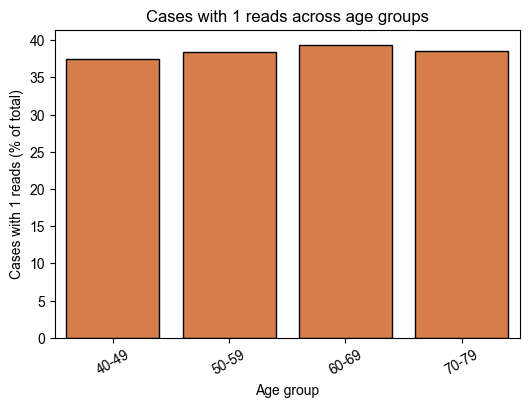

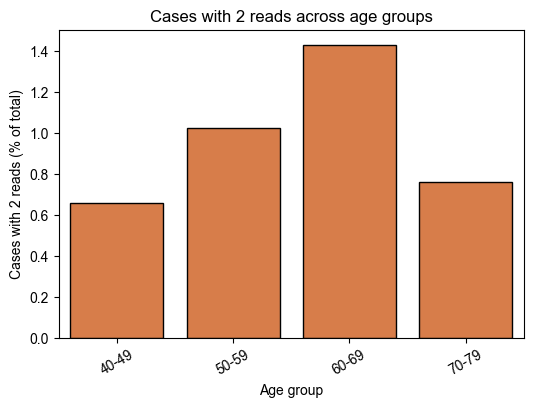

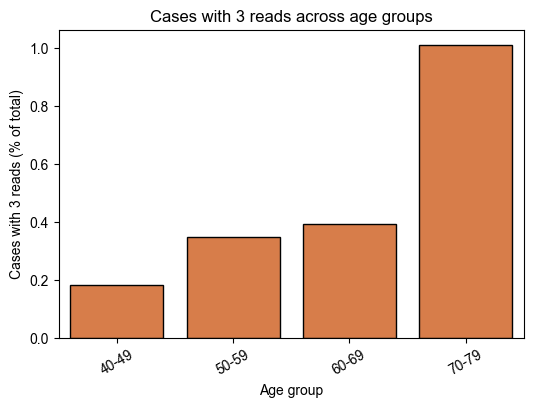

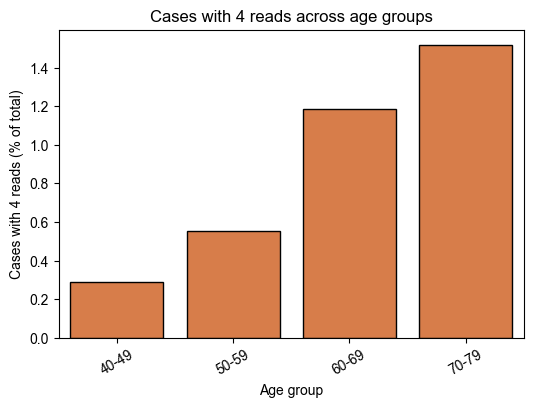

In [84]:
# Plot (larger age groups)

# number of reads to look at 
nums = [1, 2, 3, 4]

# specify color for plotting
red0 = '#ee7733'

dfs_dict = {}
    
for num in nums:

    if num < 4:
        df = batch_gene_age[batch_gene_age['var_depth'] == num] # select nr of variants
    
    if num == 4:
        df = batch_gene_age[batch_gene_age['var_depth'] >= num]
            
    # for each age group, how many people have a variant with a given nr of reads?
    df_ages = df['age_group'].value_counts() 
    df_ages = df_ages.reset_index()
    df_ages.sort_values(by = 'age_group')

    # merge 
    df_merge = pd.concat([batch_counts_ag, df_ages], axis = 1)
    df_merge = df_merge.iloc[:, [0, 1, 3]] # drop age_group duplicated column 
    df_merge[f'fraction_with_{num}_reads'] = df_merge.iloc[:, 2] / df_merge.iloc[:, 1] # calculate fraction positive 
    df_merge[f'percent_with_{num}_reads'] = df_merge[f'fraction_with_{num}_reads'] * 100 # fraction CH+ for each age group

    dfs_dict[num] = df_merge

    plt.figure(figsize=(6,4)) # set figure size
    sns.barplot(x='age_group', y=f'percent_with_{num}_reads', data=df_merge, order=age_order, color = red0, edgecolor = 'black')
    # Add labels and title
    plt.xlabel('Age group')
    plt.xticks(rotation=30)
    plt.ylabel(f'Cases with {num} reads (% of total)')
    plt.title(f'Cases with {num} reads across age groups')

    # Show the plot
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_ch_age_dependence_{num}_reads_histogram.pdf', bbox_inches='tight')


In [97]:
# okay now plot this on a single plot to make it easier to understand 

df_1read = dfs_dict[1][['age_group', 'percent_with_1_reads']]
df_2read = dfs_dict[2][['age_group', 'percent_with_2_reads']]
df_3read = dfs_dict[3][['age_group', 'percent_with_3_reads']]
df_4read = dfs_dict[4][['age_group', 'percent_with_4_reads']]

# merge dfs 
df_reads_age_merged = pd.concat([df_1read, df_2read, df_3read, df_4read], axis = 1)
df_reads_age_merged = df_reads_age_merged.loc[:, ~df_reads_age_merged.columns.duplicated()] # drop duplicated columns
df_reads_age_merged = df_reads_age_merged.sort_values(by = 'age_group')

# prepare for plotting (melt)
df_reads_age_merged_melt = pd.melt(df_reads_age_merged, id_vars = 'age_group')
df_reads_age_merged_melt.variable = df_reads_age_merged_melt.variable.astype('category')
df_reads_age_merged_melt.variable = df_reads_age_merged_melt.variable.map({'percent_with_1_reads': '1', 
                                                                            'percent_with_2_reads': '2',
                                                                            'percent_with_3_reads': '3',
                                                                            'percent_with_4_reads': '4 or more',})
df_reads_age_merged_melt.head()


,age_group,variable,value
0,40-49,1,37.437678
1,50-59,1,38.340336
2,60-69,1,39.396355
3,70-79,1,38.481013
4,40-49,2,0.658832


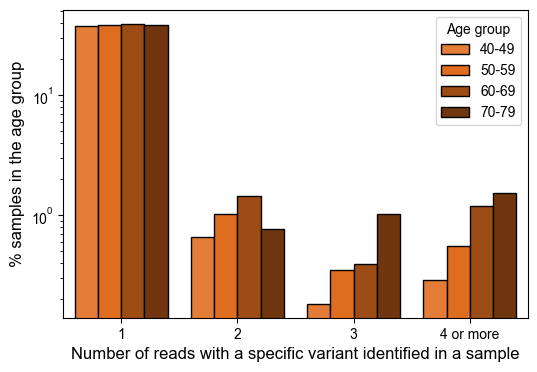

In [241]:

# plotting 
palette = ['#ff761a', '#ff6700', '#b34800', '#803300']

plt.figure(figsize = (6, 4))
sns.barplot(data = df_reads_age_merged_melt, x = 'variable', y = 'value', hue = 'age_group', palette = palette, edgecolor = 'black')
plt.yscale('log')

plt.xlabel('Number of reads with a specific variant identified in a sample', fontsize = 12)
plt.ylabel('% samples in the age group', fontsize = 12)
plt.legend(fontsize = 11)
legend = plt.legend()
legend.set_title('Age group')

plt.xticks(fontsize=10)  
plt.yticks(fontsize=10)

plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_read_nr_age_dependence_combined.pdf', bbox_inches='tight')


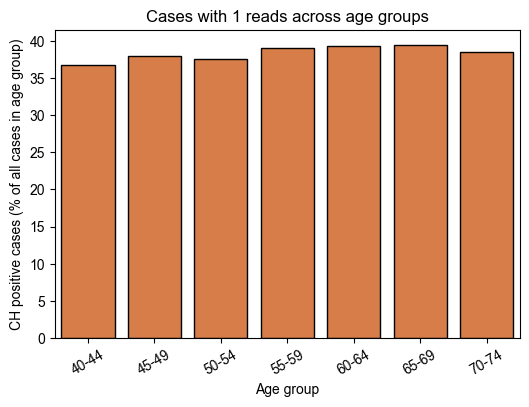

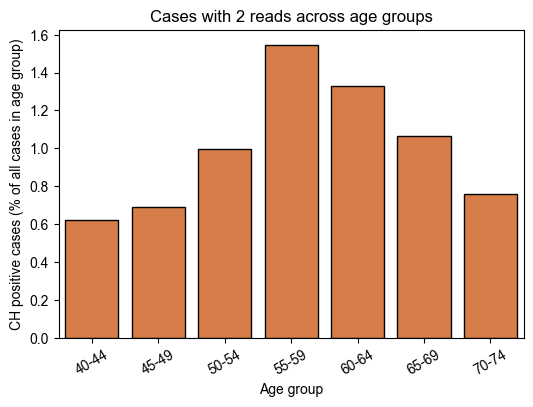

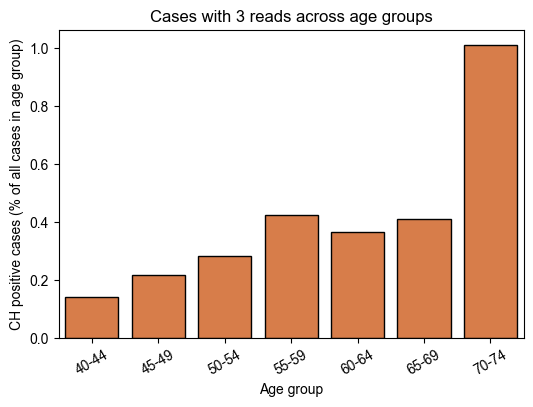

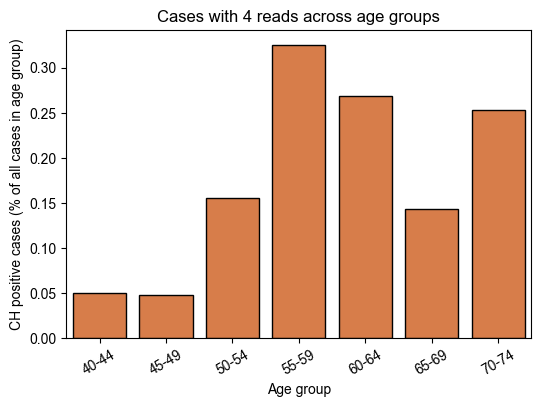

In [105]:
# Plot (smaller age groups)
# maybe the smaller age groups actually look worse in this instance

for num in nums:
    df = batch_gene_age[batch_gene_age['var_depth'] == num] # select nr of variants
            
    # for each age group, how many people have a singleton?
    df_ages = df['age_group2'].value_counts() # 
    df_ages = df_ages.reset_index()
    df_ages.sort_values(by = 'age_group2')

    # merge 
    df_merge = pd.concat([batch_counts_ag2, df_ages], axis = 1)
    df_merge = df_merge.iloc[:, [0, 1, 3]] # drop age_group duplicated column 
    df_merge['fraction_ch_positive'] = df_merge.iloc[:, 2] / df_merge.iloc[:, 1] # calculate fraction positive 
    df_merge['percent_ch_positive'] = df_merge['fraction_ch_positive'] * 100 # fraction CH+ for each age group
    df_merge = df_merge.dropna() # I dont have data for some age groups

    plt.figure(figsize=(6,4)) # set figure size
    sns.barplot(x='age_group2', y='percent_ch_positive',  data=df_merge, color = red0, edgecolor = 'black')
    # Add labels and title
    plt.xlabel('Age group')
    plt.xticks(rotation=30)
    plt.ylabel('CH positive cases (% of all cases in age group)')
    plt.title(f'Cases with {num} reads across age groups')

    # Show the plot
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_ch_age_dependence_{num}_reads_histogram_smaller_bins.pdf', bbox_inches='tight')


# Line of evidence 3: expected vs observed nr of singletons - math model

## Import the data

In [109]:

# set up a dictionary of CH cases from the UK BioBank 
# NB we ignore the fact that a lot of our reads are just a bit random and do not really correspond to the hotspots 
import csv

list_of_VAF = []
list_of_var_depths = []

# Read all batches in the folder 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls_annotated'

# Iterate over each file in the folder
for filename in os.listdir(folder_path):

    if filename.endswith(".txt"):  # search for files in the folder with a tsv extension
        file_path = os.path.join(folder_path, filename)

        with open(file_path, 'r') as csvfile:
            read_reader = csv.DictReader(csvfile, delimiter="\t")  #csv.reader returns a reader object which will iterate over lines in the csvfile
            row_count=0
            
            vaf_id_dict = {}

            for row in read_reader:
        #         print((row.keys()))
                patient_id = row['sample_ID']
                VAF = row['VAF']
                total_depth = row['depth']
                var_depth = int(row['var_depth'])
                if var_depth >=4: # select only cases where there are at least 4 reads with the variant detected 
                    list_of_VAF.append(VAF)
                    list_of_var_depths.append(var_depth)
                    vaf_id_dict[patient_id] = VAF

print('number of high VAF variants in analysis:', len(list_of_VAF))

# sanity check (loaded the correct data)
print("Example VAFs:", list_of_VAF[0:4])
print("Example variant depths:", list_of_var_depths[0:4])


number of high VAF variants in analysis: 864
Example VAFs: ['0.048780487804878', '0.1311475409836065', '0.0975609756097561', '0.5384615384615384']
Example variant depths: [4, 8, 4, 14]


In [110]:

# set up dictionary of UKBB participants 
import csv

# Read all batches in the folder 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls/batch_ids_current'

list_of_ppl_interrogated = []

for filename in os.listdir(folder_path):

    if filename.endswith(".tsv"):  # search for files in the folder with a tsv extension
        file_path = os.path.join(folder_path, filename)

        with open(file_path, 'r') as csvfile:
            read_reader = csv.DictReader(csvfile, delimiter="\t")  #csv.reader returns a reader object which will iterate over lines in the csvfile
            row_count=0

            for row in read_reader:
        
                patient_ID = row['batch ID'][0:7]
                list_of_ppl_interrogated.append(patient_ID)
            
print('number of people examined:', len(list_of_ppl_interrogated))           

filename="/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/from_gladys/ages_for_gladys_barbara.tsv"

list_of_ages = []

with open(filename, 'r') as csvfile:
    read_reader = csv.DictReader(csvfile, delimiter="\t")  #csv.reader returns a reader object which will iterate over lines in the csvfile
    row_count=0
    
    for row in read_reader:
        
        patient_age = float(row['Age.when.attended.assessment.centre_v0'])
        patient_ID = row['ID_v0']

        if patient_ID in list_of_ppl_interrogated:
            
            list_of_ages.append(patient_age)
        
print('Number of cases with age data:', len(list_of_ages)) 
print('the mean age of people in analysed batches is:', int(sum(list_of_ages) / len(list_of_ages)))
print('the max age of people in analysed batches is:', max(list_of_ages))
print('the min age of people in analysed batches is:', min(list_of_ages))       

# It throws an error (could not convert string to float: '')
# This is because in the last row, you have a black space
# You don't need to worry about it 

# note this may take a while to run 


number of people examined: 99597


ValueError: could not convert string to float: ''

## Plot the data

In [160]:

# define necessary plotting functions
def error_bars(hist, normed_value, widths):
    
    errors={}
    n=0
    for i in list(hist):
        normalised_hist = i/(normed_value*widths)
        log_hist = np.log(normalised_hist)
        sqrt_hist = math.sqrt(i)
        if sqrt_hist == 1:
            upper_error = 1
            lower_error = 0.9
        if sqrt_hist !=1:
            upper_error = sqrt_hist
            lower_error = sqrt_hist
        normalised_upper_error = upper_error/(normed_value*widths)
        normalised_lower_error = lower_error/(normed_value*widths)
        errors[n]=(normalised_hist[0], normalised_upper_error[0], normalised_lower_error[0])
        n = n+1

    errors_corrected ={}
    for k, v in errors.items():
        binheight = v[0]
        log_binheight = np.log(v[0])
        upper_error = v[1]
        lower_error = v[2]
        log_upper_error = (np.log(upper_error+binheight))-log_binheight
        log_lower_error = log_binheight-(np.log(binheight-lower_error))
        errors_corrected[k] = (log_binheight, log_upper_error, log_lower_error)

    lower_err=[]
    upper_err=[]
    for k, v in errors_corrected.items():
        lower_error = v[2]
        upper_error = v[1]
        lower_err.append(lower_error)
        upper_err.append(upper_error)

    err = [tuple(lower_err),tuple(upper_err)]
    
    return err

def log_hist_data_for_plot(study_VAFs, study_total, study_mu, bin_size):
    log_VAFs = []
    for i in study_VAFs:
        log_VAFs.append(np.log(float(i)))
    normed_value = study_total*2*study_mu
#     bin_size = int((max(log_VAFs)-min(log_VAFs))/(1/((len(log_VAFs))**(1/3))))
    hist, bins = np.histogram(log_VAFs, bins=bin_size, range=(min(log_VAFs),max(log_VAFs)))
    widths = np.diff(bins)
    bin_centres = (bins[:-1] + bins[1:])/2
    hist = np.array(hist, dtype=float)
    normalised_hist = hist/(normed_value*widths)
    log_hist_for_plot = np.log(normalised_hist)
    
    errors = error_bars(hist, normed_value, widths)
    
    return bin_centres, log_hist_for_plot, errors

def plot_log_hist_data_for_plot_normalized(study_VAFs, study_total, n_bins, lmin, lmax, study_name, marker_name, marker_size, color):
    # study_VAFs is a list of strings
    
    #for plotting graphs that will not span the full width of the page and so will need larger markers
    log_VAFs = []
    for i in study_VAFs:
        log_VAFs.append(np.log(float(i)))
    
        
    normed_value = study_total
    hist, bins = np.histogram(log_VAFs, bins=n_bins, range=(lmin, lmax))
    print('bins:', bins)
    print('Hist is:', hist)
    widths = np.diff(bins)
    bin_centres = (bins[:-1] + bins[1:])/2
#     hist = np.array(hist, dtype=float)
 

    hist_without_zero=[]
    bin_centres_without_zero=[]
    for m in range(len(hist)):
        i = hist[m]
        if i != 0:
            hist_without_zero.append(i)
            bin_centres_without_zero.append(bin_centres[m])
    print('hist without zero is', hist_without_zero)
    width_scalar=widths[0]
    normalised_hist = hist_without_zero/(normed_value*width_scalar)
    log_hist_for_plot = np.log(normalised_hist)
    
#     print('hist is of type', type(hist))
    errors = error_bars(hist_without_zero, normed_value, widths)

    axisfont=14*1.2
    axislabelfont=15*1.2
    tpfont = 14*1.2

    m_size = 15*1.2
    m_width = 1.5*1.2
    c_size = 7*1.2
    c_thick = 3*1.2
    e_width = 1.5*1.2

    ax1.errorbar(bin_centres_without_zero, log_hist_for_plot, yerr= errors, fmt = marker_name, ecolor = color, \
                 elinewidth = e_width, capsize = c_size, capthick = c_thick, markersize = marker_size, markeredgewidth = m_width, \
                 markeredgecolor = color, markerfacecolor = color, label = study_name, zorder=3)
    print('log_hist_for_plot is', log_hist_for_plot)
    print('errors is', errors)
    
    # Set axis limits
    ax1.set_ylim(min(log_hist_for_plot), max(log_hist_for_plot))
    ax1.set_xlim(np.log(10**-3), 0)
    # ax1.set_xlim(-7.6, 0)

    # Axis labels
    ax1.set_xlabel('variant allele frequency (%)', fontsize = axislabelfont, labelpad = 6*scale, fontweight = 'medium')
    ax1.set_ylabel('normalized density of variants', fontsize = axislabelfont, labelpad = 6*scale, fontweight = 'medium')

    x_major_ticks =  [np.log(0.001), np.log(0.002),np.log(0.003),np.log(0.004),np.log(0.005),np.log(0.006),np.log(0.007),np.log(0.008),np.log(0.009), \
                     np.log(0.01),np.log(0.02),np.log(0.03),np.log(0.04),np.log(0.05),np.log(0.06),np.log(0.07),np.log(0.08),np.log(0.09),\
                     np.log(0.1),np.log(0.2),np.log(0.3),np.log(0.4),np.log(0.5),np.log(0.6),np.log(0.7),np.log(0.8),np.log(0.9), np.log(1.0)]
                  
    x_major_tick_labels =  [ "0.1","","","","","","","","",\
                           "1","","","","","","","","",\
                           "10","","","","50","","","","",""]
    ax1.set_xticks(x_major_ticks)
    ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont)
    ax1.xaxis.set_tick_params(width=scale, color = 'grey', length = 6)

    y_major_ticks = [np.log(10), np.log(20), np.log(30),\
                     np.log(40), np.log(50), np.log(60), \
                     np.log(70), np.log(80), np.log(90),\
                     np.log(100), np.log(200), np.log(300), \
                     np.log(400), np.log(500), np.log(600),\
                     np.log(700), np.log(800), np.log(900), \
                     np.log(1000), np.log(2000), np.log(3000),\
                    np.log(4000), np.log(5000), np.log(6000), \
                     np.log(7000), np.log(8000), np.log(9000),\
                    np.log(10000), np.log(20000), np.log(30000), \
                     np.log(40000), np.log(50000), np.log(60000),\
                    np.log(70000), np.log(80000), np.log(90000), \
                     np.log(100000), np.log(200000),np.log(300000),np.log(400000),np.log(500000),np.log(600000),\
                    np.log(700000),np.log(800000),np.log(900000),np.log(1000000)]
    y_major_ticks = [c-np.log(10**6) for c in y_major_ticks]
    y_major_tick_labels = ["" ,"", "", "", "", "", "", "", "", \
                           "$10^{-4}$","", "", "", "", "", "", "", "", "$10^{-3}$","", "", "", "", "", "", "", "", \
                           "$10^{-2}$","", "", "", "", "", "", "", "", "$10^{-1}$","", "", "", "", "", "", "", "", "$10^{0}$"]
    ax1.set_yticks(y_major_ticks)
    ax1.set_yticklabels(y_major_tick_labels, fontsize = axisfont)
    ax1.yaxis.set_tick_params(width=scale, color = 'grey', length = 6)
    

    #Only show the required axis lines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(1.5)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_color('grey')

    return ax1

In [161]:

binmethod = 'doane'

m_size = 14
Boltonmarkersize = m_size*1
Razavimarkersize = m_size*1
Coombsmarkersize = m_size*1.2
Youngmarkersize = m_size*1.2
Desaimarkersize = m_size*1.5
Jaiswalmarkersize = m_size*1.2
Genovesemarkersize = m_size*1.1

line_width = 6
a = 0.75

bins: [-3.21887582 -2.7137301  -2.20858437 -1.70343864 -1.19829291 -0.69314718]
Hist is: [182 184 190 160  91]
hist without zero is [182, 184, 190, 160, 91]
log_hist_for_plot is [-5.62197232 -5.61104325 -5.57895493 -5.75080519 -6.3151195 ]
errors is [(0.07701596884402662, 0.07657977015279194, 0.07531383353964216, 0.08235707037558981, 0.11073994071247295), (0.07150631303305666, 0.07113016538522743, 0.07003677643879858, 0.07608745736199385, 0.09969010452588734)]


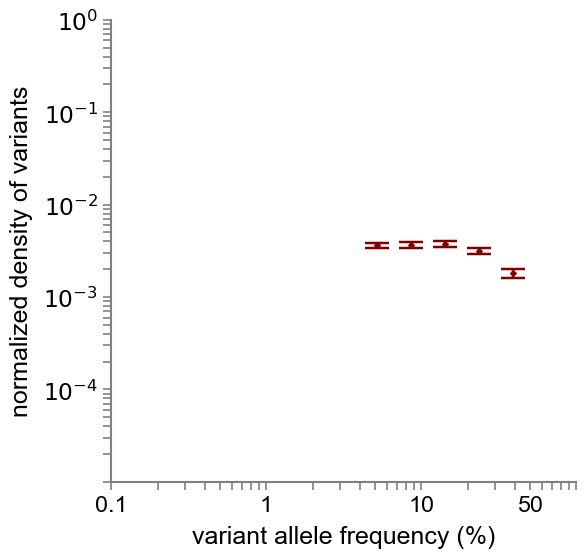

In [163]:

# plotting the histogram
plt.close('all')
scale = 1.2
f, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(4,4))

# fraction_of_drivers_that_matters = 0.6122039636083625

all468color = 'maroon'

n_bins_Bolton = 7
Boltonmarker = 'D'
lmin_Bolton = np.log(0.02)
lmax_Bolton = np.log(0.4999)
Boltonmarkersize = 2

plot_log_hist_data_for_plot_normalized(list_of_VAF, len(list_of_ages),\
                                         5, np.log(4/100), np.log(0.5),\
                            '  ', Boltonmarker, Boltonmarkersize, 'maroon')


x=np.linspace(np.log(10**-4), np.log(0.49999999999), 50)
ax1.set_ylim(np.log(10**-5), np.log(10**0))

# plt.savefig('Driver_analysis_top_291_gene_p_is_3_best_fit_DFE_with_dev_contrib_and_HH_contrib.pdf', bbox_inches='tight')
plt.show()

## Theory functions

In [164]:

# Define the theory functions
# This is the expected probability density for a single fitness and a single age 

# this is the probability density  of clone sizes that depends on age, mu, N_tau, s (f = clone size)
def rho(age, mu, N_tau, s, l):

    """
    rho of f is the expected density of the variant being present at a given frequency (2f = n / (n + N) where n is the clone size and N the total number of cells)
    N_tau is the total number of cells (= population size) * division rate 
    mu is the mutation rate 
    age is the age of the participant (> sets the maximum size of the clone assuming a given growth rate)
    s is the fitness effect of the mutation (growth rate)
    """

    theta = 2 * N_tau * mu
    fi = (np.exp(s*age) - 1) / (2 * N_tau * s)

    num = theta / (1-2*np.exp(l))
    exponent = np.exp(- ((np.exp(l))/fi) / (1 - 2*np.exp(l)) ) 
    
    rho = num * exponent

    if rho <= 0:
        return 0
    else:
        return rho


In [167]:

# format x axis ticks 
import matplotlib.ticker as ticker
def log_to_nonlog(x, pos):
    return "{:.1g}".format(np.exp(x))
  

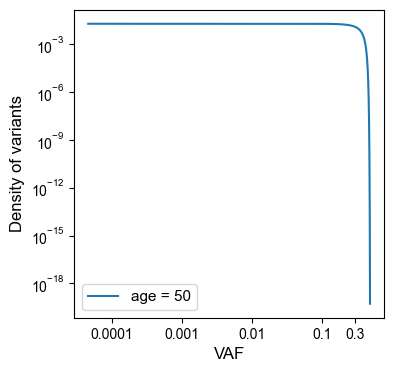

In [218]:

# this is to try this function out just on mock data 
mu = 10**-7
s = 0.2
N_tau = 10**5

list_values = np.arange(-10, np.log(0.49), 0.0001).tolist()
result = [rho(50, mu, N_tau, s, l) for l in list_values]

plt.figure(figsize = (4,4))
plt.plot(list_values, result, label = 'age = 50')
plt.yscale('log')

plt.xlabel('VAF', fontsize = 12)
plt.ylabel('Density of variants', fontsize = 12)

plt.xticks(fontsize=10)  
plt.yticks(fontsize=10)

plt.xticks([np.log(0.0001), np.log(0.001), np.log(0.01), np.log(0.1), np.log(0.3)])
formatter = ticker.FuncFormatter(log_to_nonlog)
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend(fontsize = 11)

plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_singletons_density_function_test.pdf', bbox_inches='tight')


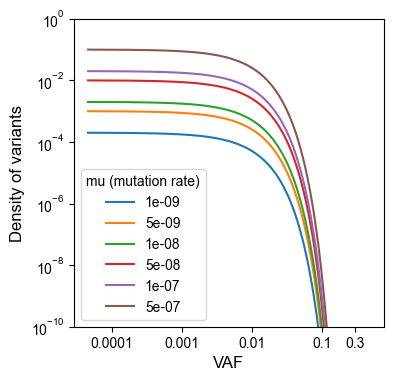

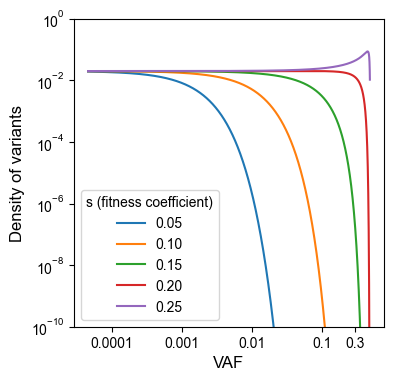

In [215]:

# check how this function behaves depending on the parameters

mus = [10**-9, 5*10**-9, 10**-8, 5*10**-8, 10**-7, 5*10**-7]
ss = [0.05, 0.10, 0.15, 0.20, 0.25]
    
plt.figure(figsize = (4,4))

for mu in mus:
    result = [rho(50, mu, 10**5, 0.1, l) for l in list_values]
    plt.plot(list_values, result, label = f'{mu}')
    plt.yscale('log')
    plt.xlabel('VAF', fontsize = 12)
    plt.ylabel(f'Density of variants', fontsize = 12)

plt.legend(loc = 'lower left', fontsize = 11)
legend = plt.legend()
legend.set_title('mu (mutation rate)')
plt.ylim(10**-10, 10**0)
    
plt.xticks(fontsize = 10)
plt.xticks(fontsize = 10)

plt.xticks([np.log(0.0001), np.log(0.001), np.log(0.01), np.log(0.1), np.log(0.3)])
formatter = ticker.FuncFormatter(log_to_nonlog)
plt.gca().xaxis.set_major_formatter(formatter)
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_singletons_effects_of_mu.pdf', bbox_inches='tight')

plt.figure(figsize = (4,4))

for s in ss:
    result = [rho(50, 10**-7, 10**5, s, l) for l in list_values]
    plt.plot(list_values, result, label = f'{s:.2f}')
    plt.yscale('log')
    plt.xlabel('VAF', fontsize = 12)
    plt.ylabel(f'Density of variants', fontsize = 12)

plt.legend(loc = 'lower left', fontsize = 11)
legend = plt.legend()
legend.set_title('s (fitness coefficient)')

plt.ylim(10**-10, 10**0)

plt.xticks(fontsize = 10)
plt.xticks(fontsize = 10)

plt.xticks([np.log(0.0001), np.log(0.001), np.log(0.01), np.log(0.1), np.log(0.3)])
formatter = ticker.FuncFormatter(log_to_nonlog)
plt.gca().xaxis.set_major_formatter(formatter)

plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_singletons_effects_of_s.pdf', bbox_inches='tight')


## Age distribution in the population

Age bins examined: [(40, 44), (45, 49), (50, 54), (55, 59), (60, 64), (65, 69), (70, 74)]
The fraction of people in the UKBB in a given age group: [0.10407944014377943, 0.13147986385132082, 0.15192224665401569, 0.17842906914866913, 0.24155346044559575, 0.1876763356325994, 0.0048093818086890165]
The total fraction of the population covered: 0.9999497976846693


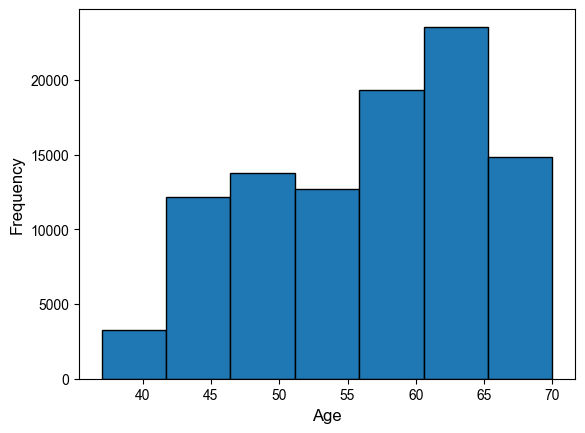

In [170]:

# I am going to be doing a weighed sum across age bins, so I need to know how many people I have in each age group

plt.hist(list_of_ages, bins = 7, edgecolor = 'black')
plt.xlabel('Age', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_age_distribution_in_the_UKBB.pdf', bbox_inches='tight')

# I need the distribution of age groups
def count_values_in_intervals(value_list, interval_list):
    counts = [0] * len(interval_list)

    for value in value_list:
        for i, (lower, upper) in enumerate(interval_list):
            if lower <= value <= upper:
                counts[i] += 1
                break

    return counts

intervals = [(40, 44), (45, 49), (50, 54), (55, 59), (60, 64), (65, 69), (70, 74)]
counts_ages = count_values_in_intervals(list_of_ages, intervals)
fraction_ages = [c / len(list_of_ages) for c in counts_ages] # you will want to take a weighed sum of this 

print('Age bins examined:', intervals)
print('The fraction of people in the UKBB in a given age group:', fraction_ages)
print('The total fraction of the population covered:', sum(fraction_ages)) #sums up to ~0.999 so this suggests this is a correct thing 

In [171]:

# age bins
mean_age = [42, 47, 52, 57, 62, 67, 72]
ages_df = pd.concat([pd.DataFrame(fraction_ages), pd.DataFrame(mean_age)], axis = 1)
ages_df.columns = ['fraction', 'mean_age']
ages_df

,fraction,mean_age
0,0.104079,42
1,0.131480,47
2,0.151922,52
3,0.178429,57
4,0.241553,62
5,0.187676,67
6,0.004809,72



## Weighted sum

In [220]:

# here are some parameters
mu = 10**-7
s = 0.12
N_tau = 10**5

list_values = np.arange(-10, np.log(0.49999), 0.0001).tolist()

# initialize the array to write to 
weighted_sum = np.zeros_like(list_values)

# these are the ages and the corresponding fraction of the population in a given age bin
ages = [42, 47, 52, 57, 62, 67, 72] # age values 
weights = fraction_ages # you calculated the fraction of people in this age bin here 

# calculate the weighed sum (weighed by fraction of people in a given age group)
for age, weight in zip(ages, weights):
    exp_distribution = [rho(age, mu, N_tau, s, l) for l in list_values] 
    weighted_sum += [weight * c for c in exp_distribution]


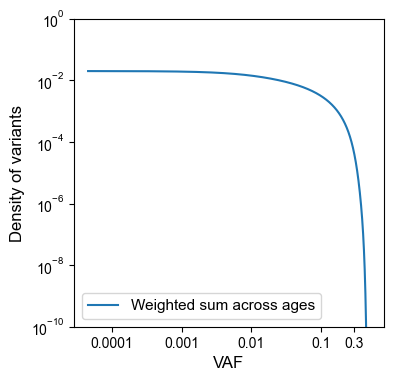

In [221]:

# plot the figure 
plt.figure(figsize = (4,4))

plt.plot(list_values, weighted_sum, label='Weighted sum across ages')
plt.yscale('log')
plt.ylim(10**-10, 10**0)

plt.xlabel('VAF', fontsize = 12)
plt.ylabel('Density of variants', fontsize = 12)
plt.legend(fontsize = 11, loc = 'lower left')

plt.xticks([np.log(0.0001), np.log(0.001), np.log(0.01), np.log(0.1), np.log(0.3)])
formatter = ticker.FuncFormatter(log_to_nonlog)
plt.gca().xaxis.set_major_formatter(formatter)

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_singletons_weighted_sum.pdf', bbox_inches='tight')


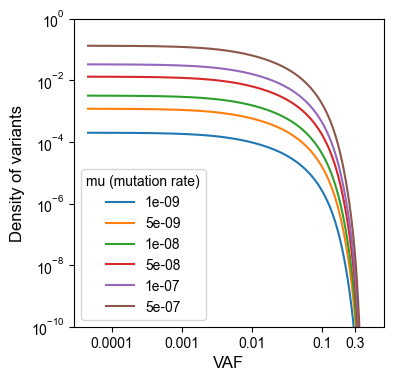

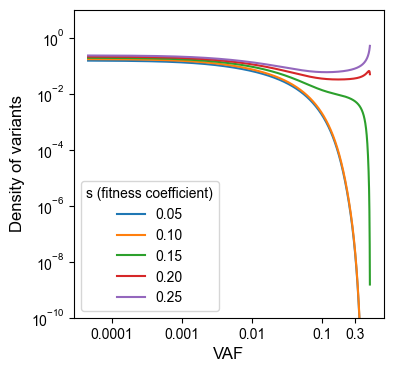

In [216]:

# examine impact of mu and s 
weighted_sum = np.zeros_like(list_values)

# these are the ages and the corresponding fraction of the population in a given age bin
ages = [42, 47, 52, 57, 62, 67, 72] # age values 
weights = fraction_ages # you calculated the fraction of people in this age bin here 

mus = [10**-9, 5*10**-9, 10**-8, 5*10**-8, 10**-7, 5*10**-7]
ss = [0.05, 0.10, 0.15, 0.20, 0.25]
  
# calculate the weighed sum (weighed by fraction of people in a given age group)
plt.figure(figsize = (4,4))
for mu in mus:
    for age, weight in zip(ages, weights):
        exp_distribution = [rho(age, mu, 10**5, 0.1, l) for l in list_values] 
        weighted_sum += [weight * c for c in exp_distribution]
    plt.plot(list_values, weighted_sum, label=f'{mu}')
    plt.yscale('log')
    plt.xlabel('VAF', fontsize = 12)
    plt.ylabel('Density of variants', fontsize = 12)
    plt.ylim(10**-10, 10**0)

plt.legend(fontsize = 11)
legend = plt.legend()
legend.set_title('mu (mutation rate)')

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.xticks([np.log(0.0001), np.log(0.001), np.log(0.01), np.log(0.1), np.log(0.3)])
formatter = ticker.FuncFormatter(log_to_nonlog)
plt.gca().xaxis.set_major_formatter(formatter)
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_weighted_sum_effects_of_mu.pdf', bbox_inches='tight')

plt.figure(figsize = (4,4))
    
for s in ss:
    for age, weight in zip(ages, weights):
        exp_distribution = [rho(age, 10**-7, 10**5, s, l) for l in list_values] 
        weighted_sum += [weight * c for c in exp_distribution]
    plt.plot(list_values, weighted_sum, label=f'{s:.2f}')
    plt.yscale('log')
    plt.xlabel('VAF', fontsize = 12)
    plt.ylabel('Density of variants', fontsize = 12)
    plt.ylim(10**-10, 10**1)

plt.legend(fontsize = 11)
legend = plt.legend()
legend.set_title('s (fitness coefficient)')

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.xticks([np.log(0.0001), np.log(0.001), np.log(0.01), np.log(0.1), np.log(0.3)])
formatter = ticker.FuncFormatter(log_to_nonlog)
plt.gca().xaxis.set_major_formatter(formatter)

plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_weighted_sum_effects_of_s.pdf', bbox_inches='tight')


## Make predictions for discrete numbers of reads

In [149]:

# define functions for binomial subsampling and total probability
from math import comb

# probability that you see a certain number of reads given coverage (from binomial)
def prob_of_n_reads_from_binomial_subsampling(l, total_depth, var_depth):
    return comb(total_depth, var_depth)*(np.exp(l)**var_depth)*(1-np.exp(l))**(total_depth-var_depth) # l has been logged so we need to exponentiate to get back to percentage 

# total probability (binomial * predicted density of the clone size)
def prob_of_n_reads_across_all_VAFs(l_vector, fitted_VAF, total_depth, var_depth):
    l_diff = l_vector[1]-l_vector[0]
    
    total_prob = 0
    for l, log_rho in zip(l_vector, fitted_VAF):
        prob_of_variant_at_l = np.exp(log_rho)*l_diff 
        # rho is the estimated probability and it also has been logged
        # probability of variant at l calculated the area under the rho curve for a given l interval 

        total_depth = int(total_depth) # we need to do this because you are doing (N choose n) so you need integers
        subsampling_prob = prob_of_n_reads_from_binomial_subsampling(l, total_depth, var_depth) # B(p, n) ~ B(l, total depth); l = VAF
        contrib = prob_of_variant_at_l*subsampling_prob
        total_prob += contrib # this is equivalent to saying total_prob = total_prob + contrib 
        
    return total_prob

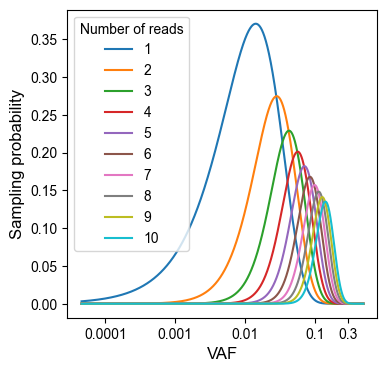

In [222]:

# check that these functions are doing what you think they are
var_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
total_depth = 70

plt.figure(figsize = (4,4))
for v in var_depths:
    results = []
    for l in list_values:
        res = prob_of_n_reads_from_binomial_subsampling(l, total_depth, v)
        results.append(res)
    plt.plot(list_values, results, label = f'{v}')
    plt.xlabel('VAF', fontsize = 12)
    plt.ylabel('Sampling probability', fontsize = 12)
    
plt.legend(loc = 'upper left', fontsize = 11)
legend = plt.legend()
legend.set_title('Number of reads')

plt.xticks([np.log(0.0001), np.log(0.001), np.log(0.01), np.log(0.1), np.log(0.3)])
formatter = ticker.FuncFormatter(log_to_nonlog)
plt.gca().xaxis.set_major_formatter(formatter)

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_binomial_p_sampling_n_reads.pdf', bbox_inches='tight')


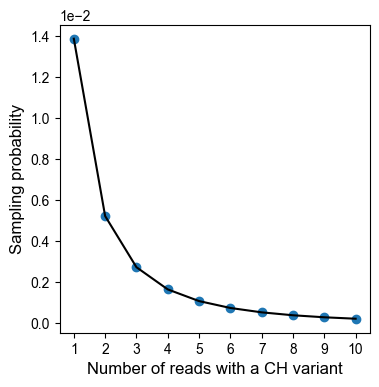

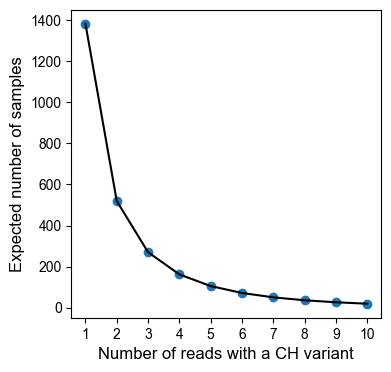

In [224]:

# check 2

var_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
total_depth = 70

list_values = np.arange(-10, np.log(0.49999), 0.0001).tolist()
weighted_sum = np.zeros_like(list_values)
ages = [42, 47, 52, 57, 62, 67, 72] # age values 
weights = fraction_ages # you calculated the fraction of people in this age bin here 
for age, weight in zip(ages, weights):
    exp_distribution = [rho(age, mu, N_tau, s, l) for l in list_values] 
    weighted_sum += [weight * c for c in exp_distribution]
fitted = np.log(weighted_sum)

results = []
for v in var_depths:
    res = prob_of_n_reads_across_all_VAFs(list_values, fitted, 70, v)
    results.append(res)

plt.figure(figsize = (4,4))
plt.scatter(var_depths, results)
plt.plot(var_depths, results, color = 'black')
plt.xlabel('Number of reads with a CH variant', fontsize = 12)
plt.ylabel('Sampling probability', fontsize = 12)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_binomial_total_p_sample_n_reads.pdf', bbox_inches='tight')

# plot expected number of people
expected_nr = [r * len(list_of_ppl_interrogated) for r in results]
plt.figure(figsize = (4,4))
plt.scatter(var_depths, expected_nr)
plt.plot(var_depths, expected_nr, color = 'black')
plt.xlabel('Number of reads with a CH variant', fontsize = 12)
plt.ylabel('Expected number of samples', fontsize = 12)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_expected_nr_people_sample_n_reads.pdf', bbox_inches='tight')


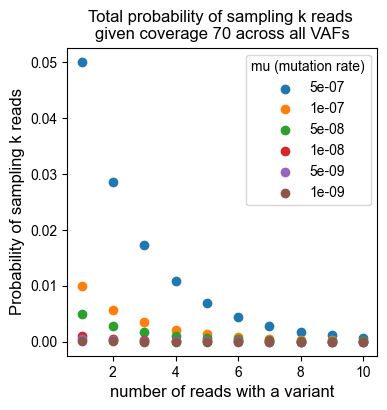

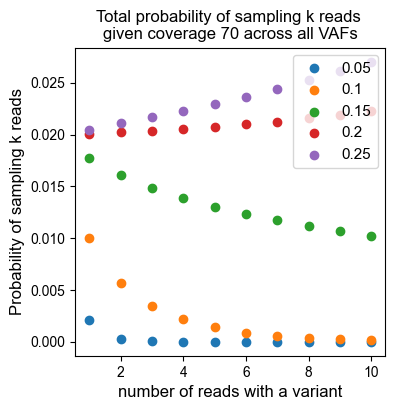

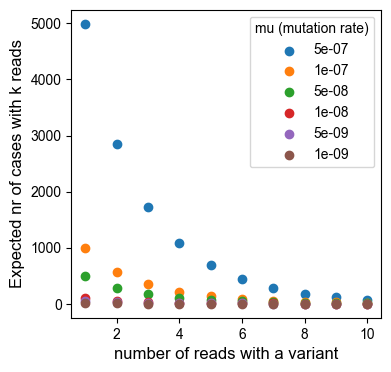

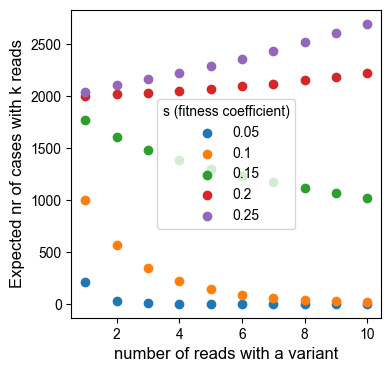

In [183]:

# check 2

mus = [10**-7, 5*10**-7, 10**-8, 5*10**-8, 10**-9, 5*10**-9]
ss = [0.05, 0.10, 0.15, 0.20, 0.25]

var_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
total_depth = 70
list_values = np.arange(-10, np.log(0.49999), 0.0001).tolist()

plt.figure(figsize = (4,4))

ages = [42, 47, 52, 57, 62, 67, 72] # age values 
weights = fraction_ages

for mu in mus:
    
    weighted_sum = np.zeros_like(list_values)
    res_fitted = []
    
    for v in var_depths:

        # you calculated the fraction of people in this age bin here 
        for age, weight in zip(ages, weights):
            exp_distribution = [rho(age, mu, 10**5, 0.1, l) for l in list_values] 
            weighted_sum += [weight * c for c in exp_distribution]
        
        fitted = np.log(weighted_sum)
        res = prob_of_n_reads_across_all_VAFs(list_values, fitted, 70, v)
        res_fitted.append(res)

    plt.scatter(var_depths, res_fitted, label = f'{mu}')
    plt.xlabel('number of reads with a variant', fontsize = 12)
    plt.ylabel('Probability of sampling k reads', fontsize = 12)

plt.legend(fontsize = 11)
legend = plt.legend()
legend.set_title('mu (mutation rate)')
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_binomial_total_p_sample_n_reads_by_mu.pdf', bbox_inches='tight')

plt.figure(figsize = (4,4))
for s in ss:
    
    weighted_sum = np.zeros_like(list_values)
    res_fitted = []
    
    for v in var_depths:

        # you calculated the fraction of people in this age bin here 
        for age, weight in zip(ages, weights):
            exp_distribution = [rho(age, 10**-7, 10**5, s, l) for l in list_values] 
            weighted_sum += [weight * c for c in exp_distribution]
        
        fitted = np.log(weighted_sum)
        res = prob_of_n_reads_across_all_VAFs(list_values, fitted, 70, v)
        res_fitted.append(res)

    plt.scatter(var_depths, res_fitted, label = f'{s}')
    plt.xlabel('number of reads with a variant', fontsize = 12)
    plt.ylabel('Probability of sampling k reads', fontsize = 12)

plt.legend(fontsize = 11, loc = 'upper right')
legend = plt.legend()
legend.set_title('s (fitness coefficient)')
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_binomial_total_p_sample_n_read_by_s.pdf', bbox_inches='tight')

# plot expected number of people
plt.figure(figsize = (4,4))
for mu in mus:
    
    weighted_sum = np.zeros_like(list_values)
    res_fitted = []
    
    for v in var_depths:

        # you calculated the fraction of people in this age bin here 
        for age, weight in zip(ages, weights):
            exp_distribution = [rho(age, mu, 10**5, 0.1, l) for l in list_values] 
            weighted_sum += [weight * c for c in exp_distribution]
        
        fitted = np.log(weighted_sum)
        res = prob_of_n_reads_across_all_VAFs(list_values, fitted, 70, v)
        res_fitted.append(res)
        expected_nr = [r * len(list_of_ppl_interrogated) for r in res_fitted]

    plt.scatter(var_depths, expected_nr, label = f'{mu}')
    plt.xlabel('number of reads with a variant', fontsize = 12)
    plt.ylabel('Expected nr of cases with k reads', fontsize = 12)

plt.legend(fontsize = 11, loc = 'upper right')
legend = plt.legend()
legend.set_title('mu (mutation rate)')
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_expected_nr_people_sample_n_reads_by_mu.pdf', bbox_inches='tight')

plt.figure(figsize = (4,4))
for s in ss:
    
    weighted_sum = np.zeros_like(list_values)
    res_fitted = []
    
    for v in var_depths:

        # you calculated the fraction of people in this age bin here 
        for age, weight in zip(ages, weights):
            exp_distribution = [rho(age, 10**-7, 10**5, s, l) for l in list_values] 
            weighted_sum += [weight * c for c in exp_distribution]
        
        fitted = np.log(weighted_sum)
        res = prob_of_n_reads_across_all_VAFs(list_values, fitted, 70, v)
        res_fitted.append(res)
        expected_nr = [r * len(list_of_ppl_interrogated) for r in res_fitted]

    plt.scatter(var_depths, expected_nr, label = f'{s}')
    plt.xlabel('number of reads with a variant', fontsize = 12)
    plt.ylabel('Expected nr of cases with k reads', fontsize = 12)

plt.legend(fontsize = 11, loc = 'upper right')
legend = plt.legend()
legend.set_title('s (fitness coefficient)')
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_expected_nr_people_sample_n_reads_by_s.pdf', bbox_inches='tight')


## Expectation based on theory

In [184]:

# Create an expectation based on the theory 

# parameters 
mu = 10**-7
s = 0.12
N_tau = 10**5

# VAF values 
list_values = np.arange(-10, np.log(0.49999), 0.0001).tolist() # you are NOT using your VAF values, just any  

# calculate the weighed sum given the age distribution 
ages = [42, 47, 52, 57, 62, 67, 72] # age values 
weights = fraction_ages # you calculated the fraction of people in this age bin here 

weighted_sum = np.zeros_like(list_values)
for age, weight in zip(ages, weights):
    exp_distribution = [rho(age, mu, N_tau, s, l) for l in list_values] 
    weighted_sum += [weight * c for c in exp_distribution]
fitted = np.log(weighted_sum)

# obtain the expected number of people with a given number of reads 
expected_counts = {}
for i in list(range(4,11)):
    expected_counts[i] = int(prob_of_n_reads_across_all_VAFs(list_values, fitted , 70, i) * len(list_of_ppl_interrogated))

# now, this is our expectation for some set of parameters 
# we would like this to match the observed number 
expected_counts
expected_counts_df = pd.DataFrame(expected_counts, index = ['read count']).T
expected_counts_df = expected_counts_df.reset_index()
expected_counts_df.columns.values[0] = 'read number'
expected_counts_df = expected_counts_df.sort_values(by = 'read number')
expected_counts_df


,read number,read count
0,4,162
1,5,105
2,6,71
3,7,50
4,8,36
5,9,26
6,10,19


## Get observed data

### ALL observed data

In [185]:

# OBSERVED 

# create the dataframe with observed read counts 
vardepths_counts = {}

# take list of variant depths (ie number of reads that contain a given CH variant)
for element in list_of_var_depths:
    if element in vardepths_counts:
        vardepths_counts[element] += 1
    else:
        vardepths_counts[element] = 1

observed_counts = pd.DataFrame(vardepths_counts, index = ['read count']).T
observed_counts = observed_counts.reset_index()
observed_counts.columns.values[0] = 'read number'
observed_counts = observed_counts.sort_values(by = 'read number')

# let's say we are only interested in 4 - 9
observed_counts = observed_counts[observed_counts['read number'] <= 10]
observed_counts


,read number,read count
0,4,195
3,5,133
5,6,102
7,7,60
1,8,48
8,9,37
9,10,37


### ONLY CH VARIANTS observed 
### I will use these for fitting (because these are the only CH-relevant)

In [186]:

# I want to use the number of reads that correspond to actual CH variants, not errors

# import the data 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls_annotated'  # Path to ukb files from Hamish 

# Get all files in the folder 
files = glob.glob(os.path.join(folder_path, '*.txt'))  
# print('Files examined are:', files)

# Initialize an empty dictionary 
dataframes = {}

# Iterate through the CSV files and read each one with pandas
for csv_file in files:
    
    # Use pandas.read_csv to read the CSV file into a df
    df = pd.read_csv(csv_file, sep = '\t')

    # Store the df in the dictionary with the file name as the key
    dataframes[csv_file] = df

# extract dataframes 
for file_name, df in dataframes.items():
    
    # Construct variable names dynamically based on file names
    variable_name = file_name.split('/')[8].split('.')[0] + '_data'  # Removing the file extension
    df['batch'] = variable_name # add column to indicate source 

    globals()[variable_name] = df  # Assign the DataFrame to a variable with the file name


# contact all into one df
dfs_to_concat = [v for k, v in globals().items() if k.endswith('_data') and isinstance(v, pd.DataFrame)]

# Row bind all batch dataframes into a single one 
batch_all = pd.concat(dfs_to_concat, ignore_index=True)
batch_all = batch_all.dropna(subset=['batch']) # remove rows which are read incorrectly (w/o batch number)

# create new useful columns (annotation)
batch_all['end_position'] = batch_all['end_position'].astype(int)
batch_all['position'] = batch_all['position'].astype(int)
batch_all['sample_ID'] = batch_all['sample_ID'].astype(int)

# subset and create new useful columns
batch_all = batch_all[['sample_ID', 'chromosome', 'end_position', 'VAF', 'var_depth', 'depth', 'Amino_acids', 'SYMBOL', 'Codons', 'batch']]
batch_all['alt_variant'] = batch_all['Amino_acids'].str.split('/', expand = True)[1]
batch_all['ref_variant'] = batch_all['Amino_acids'].str.split('/', expand = True)[0]

# subset the data such that only variants with >= 4 reads are considered
batch_all_ns = batch_all[batch_all['var_depth'] >= 4]

# create column with coordinates such that you can merge annotation (on genetic variant name)
batch_all_ns['variant_coord'] = batch_all_ns['chromosome'].astype(str) + "_" + batch_all_ns['end_position'].astype(str) 
batch_all_ns['variant_coord'] = batch_all_ns['variant_coord'].astype('category')
batch_all_ns['variant_coord_pos'] = batch_all_ns['variant_coord'].astype(str) +  "_" + batch_all_ns['SYMBOL'].astype(str) + "_" + batch_all_ns['ref_variant'].astype(str) + "_" + batch_all_ns['alt_variant'].astype(str)
batch_all_ns['variant_coord_pos'] = batch_all_ns['variant_coord_pos'].astype('category')

num_variants = pd.DataFrame(batch_all_ns['variant_coord'].value_counts())
num_variants = num_variants.sort_values(by = 'count')
num_variants['variant_coord'] = num_variants.index
num_variants = num_variants.reset_index(drop=True)
num_variants = num_variants.sort_values(by = 'variant_coord')
coord_out = num_variants['variant_coord'].tolist() # all coordinates in the batches  

# import coordinate data 
coord_gene_var = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ch_variants_coordinates_tp53_added_nts.csv')

# create required column
coord_gene_var['variant_coord'] = coord_gene_var['chromosome'] + "_" + coord_gene_var['end_position'].astype(str)
coord_gene_var['SYMBOL'] = coord_gene_var['gene_var'].str.split('_').str[0]
coord_gene_var['ref_variant'] = coord_gene_var['gene_var'].str.split('_').str[1].str[0]
coord_gene_var['alt_variant'] = coord_gene_var['gene_var'].str.split('_').str[1].str[-1]
coord_gene_var['variant_coord_pos'] = coord_gene_var['variant_coord'].astype(str) + "_" + coord_gene_var['SYMBOL'].astype(str) + "_" + coord_gene_var['ref_variant'].astype(str) + "_" + coord_gene_var['alt_variant'].astype(str)

# intersection (annotate)
coord_gene_var['variant_coord'] = coord_gene_var['chromosome'] + "_" + coord_gene_var['end_position'].astype(str)
coord_gene_var['SYMBOL'] = coord_gene_var['gene_var'].str.split('_').str[0]
coord_gene_var['ref_variant'] = coord_gene_var['gene_var'].str.split('_').str[1].str[0]
coord_gene_var['alt_variant'] = coord_gene_var['gene_var'].str.split('_').str[1].str[-1]
coord_gene_var['variant_coord_pos'] = coord_gene_var['variant_coord'].astype(str) + "_" + coord_gene_var['SYMBOL'].astype(str) + "_" + coord_gene_var['ref_variant'].astype(str) + "_" + coord_gene_var['alt_variant'].astype(str)

# merge
gene_vars = coord_gene_var[['variant_coord_pos', 'gene_var']] # subset batch df to only include variants which were successfully identified 
batch_gene_vars = pd.merge(batch_all_ns, gene_vars, on = 'variant_coord_pos', how = 'inner')
batch_gene_vars['gene_var'] = batch_gene_vars['gene_var'].astype('category')

list_of_VAF_vars = batch_gene_vars.VAF.tolist()
list_of_var_depth_vars = batch_gene_vars.var_depth.tolist()

print('Number of samples examined:', len(list_of_VAF_vars))

Number of samples examined: 786


In [187]:

# OBSERVED: only CH variants included

observed_counts = {}

for element in list_of_var_depth_vars:
    if element in observed_counts:
        observed_counts[element] += 1
    else:
        observed_counts[element] = 1


observed_counts_df = pd.DataFrame(observed_counts, index = ['read count']).T
observed_counts_df = observed_counts_df.reset_index()
observed_counts_df.columns.values[0] = 'read number'
observed_counts_df = observed_counts_df.sort_values(by = 'read number')

# let's say we are only interested in 4 - 9
observed_counts_df = observed_counts_df[observed_counts_df['read number'] < 10]
observed_counts_df

,read number,read count
0,4.0,182
1,5.0,124
2,6.0,93
9,7.0,52
16,8.0,41
15,9.0,33


## Grid search optimization

In [188]:
# optimize the fit 

observed_counts_df.rename(columns={'read count': 'observed read count'}, inplace=True) # rename column in observed data 
expected_counts_df.rename(columns={'read count': 'expected read count'}, inplace=True) # rename column in observed data 
exp_obs = pd.merge(observed_counts_df, expected_counts_df, on = 'read number') # merge 
exp_obs

,read number,observed read count,expected read count
0,4.0,182,162
1,5.0,124,105
2,6.0,93,71
3,7.0,52,50
4,8.0,41,36
5,9.0,33,26


In [189]:

# optimize

# define functions needed to do grid search 
import numpy as np
from sklearn.metrics import mean_squared_error

# define a function to get the expected data points depending on s and mu
def get_expectation(mu, s):
    
    # N_tau is a parameter but we fix the value at 10**5 
    N_tau = 10**5

    # VAF values 
    list_values = np.arange(-10, np.log(0.49999), 0.0001).tolist() # you are NOT using your VAF values, just any plausible values  

    # calculate the weighed sum given the age distribution 
    ages = [42, 47, 52, 57, 62, 67, 72]
    weights = fraction_ages 

    weighted_sum = np.zeros_like(list_values)
    for age, weight in zip(ages, weights):
        exp_distribution = [rho(age, mu, N_tau, s, l) for l in list_values] # generate the prediction 
        weighted_sum += [weight * c for c in exp_distribution]
    fitted = np.log(weighted_sum)

    # obtain the expected number of people with a given number of reads 
    expected_counts = {}
    expected_counts_list = []
    for i in list(range(4,10)):
        exp_nr_cases = int(prob_of_n_reads_across_all_VAFs(list_values, fitted , 70, i) * len(list_of_ppl_interrogated))
        expected_counts[i] = exp_nr_cases
        expected_counts_list.append(exp_nr_cases)

    return expected_counts_list 

# define how good the fit is 
def fitness_score(observed, expected):
    return mean_squared_error(observed, expected)

# define the function to do grid search 
def grid_search(mu_values, s_values, observed_values):
    best_score = float('inf')  # Initialize best score with infinity
    best_params = None         # Initialize best parameters
    
    for mu in mu_values:
        for s in s_values:
            # Generate expected data points using the current parameter combination
            expected_values = get_expectation(mu, s)
            
            # Calculate fitness score
            score = fitness_score(observed_values, expected_values)
            print(score)
            
            # Check if the current score is better than the previous best score
            if score < best_score:
                best_score = score
                best_params = (mu, s)
            
    return best_params


In [190]:

# run grid search 
# list of observed data
import numpy as np

observed_values = observed_counts_df['observed read count'].tolist()

# Grid search
best_score = float('inf')  # Initialize best score with infinity
best_params = None         # Initialize best parameters

# Initialize parameter values
mu_values = [10**-7, 5*10**-7, 10**-8, 5*10**-8, 10**-9]
s_values = [0.10, 0.125, 0.15, 0.175, 0.20]

best_params_dict = {}

# iterate 
for i in range(5):  # repeat 5 times 
    best_params = grid_search(mu_values, s_values, observed_values)
    best_params_dict[i] = best_params
    
    # search values around best parameters 
    mu_values = np.linspace(max(best_params[0] * 0.5, 0), best_params[0] * 2, 5)  # values around
    s_values = np.linspace(max(best_params[1] - 0.05, 0), best_params[1] + 0.05, 5)  # values around 
     
    print("Iteration", i+1, "Best parameters:", best_params)


6092.833333333333
87.5
14461.833333333334
43131.833333333336
69192.66666666667
1481.0
199110.83333333334
997131.1666666666
2043579.0
2895221.0
10025.166666666666
8376.333333333334
6599.666666666667
5361.0
4720.166666666667
8150.333333333333
2288.0
429.3333333333333
3497.3333333333335
7492.5
10437.166666666666
10335.5
10071.833333333334
9941.833333333334
9785.333333333334
Iteration 1 Best parameters: (1e-07, 0.125)
10316.5
8150.333333333333
2288.0
429.3333333333333
3497.3333333333335
10215.5
6569.5
74.33333333333333
8725.666666666666
28927.833333333332
10096.833333333334
5151.666666666667
1238.3333333333333
30554.333333333332
80674.66666666667
10038.0
3973.8333333333335
5835.333333333333
66057.83333333333
158486.83333333334
9880.5
2954.1666666666665
13782.5
114979.83333333333
262637.8333333333
Iteration 2 Best parameters: (8.75e-08, 0.125)
10376.666666666666
8440.666666666666
2981.0
363.8333333333333
1809.3333333333333
10256.666666666666
7000.833333333333
373.6666666666667
4878.0
18803.

In [191]:

# compare scores across values of best parameters 
print(fitness_score(observed_values, get_expectation(1e-07, 0.125)))
print(fitness_score(observed_values,get_expectation(8.75e-08, 0.125)))
print(fitness_score(observed_values,get_expectation(1.0937499999999999e-07, 0.125)))
print(fitness_score(observed_values,get_expectation(9.570312499999998e-08, 0.125)))
print(fitness_score(observed_values,get_expectation(8.374023437499998e-08, 0.125)))

87.5
74.33333333333333
344.8333333333333
40.666666666666664
149.83333333333334


In [192]:

# so far, the best parameters are: 9.570312499999998e-08, 0.125
current_mu = 9.570312499999998e-08
current_s = 0.125

range_size_mu = 1*10**-8
range_size_s = 0.05

mu_range = np.linspace(current_mu - range_size_mu, current_mu + range_size_mu, num=20)
s_range = np.linspace(current_s - range_size_s, current_s + range_size_s, num=20)

# Perform grid search
best_fit = float('inf')
best_params = None # no best parameters at first 

fits = []

for mu in mu_range:
    for s in s_range:
        
        # get the result of the function 
        expected_values = get_expectation(mu, s)

        # check the fit 
        fit_metric = fitness_score(observed_values, expected_values)
        fits.append(fit_metric)
        
        # update best fit and best parameters 
        if fit_metric < best_fit:
            best_fit = fit_metric
            best_params = (mu, s)

print("Best parameters:", best_params)
print("Best fit:", best_fit)


Best parameters: (1.0359786184210525e-07, 0.12236842105263157)
Best fit: 27.5


## Make prediction of the number of samples with a given readcount 

In [193]:

# EXPECTED

# parameters 
mu = 1.0359786184210525e-07 # parameters which we found work well
s = 0.122368
N_tau = 10**5

# VAF values 
list_values = np.arange(-10, np.log(0.49999), 0.0001).tolist() # you are NOT using your VAF values, just any  

# calculate the weighed sum given the age distribution 
ages = [42, 47, 52, 57, 62, 67, 72] # age values 
weights = fraction_ages # you calculated the fraction of people in this age bin here 

weighted_sum = np.zeros_like(list_values)
for age, weight in zip(ages, weights):
    exp_distribution = [rho(age, mu, N_tau, s, l) for l in list_values] 
    weighted_sum += [weight * c for c in exp_distribution]
fitted = np.log(weighted_sum)

# obtain the expected number of people with a given number of reads 
expected_counts = {}
for i in list(range(4,11)):
    expected_counts[i] = int(prob_of_n_reads_across_all_VAFs(list_values, fitted , 70, i) * len(list_of_ppl_interrogated))

# now, this is our expectation for some set of parameters 
# we would like this to match the observed number 
expected_counts
expected_counts_df = pd.DataFrame(expected_counts, index = ['read count']).T
expected_counts_df = expected_counts_df.reset_index()
expected_counts_df.columns.values[0] = 'read number'
expected_counts_df = expected_counts_df.sort_values(by = 'read number')
expected_counts_df = expected_counts_df.rename(columns={'read count': 'expected read count'})


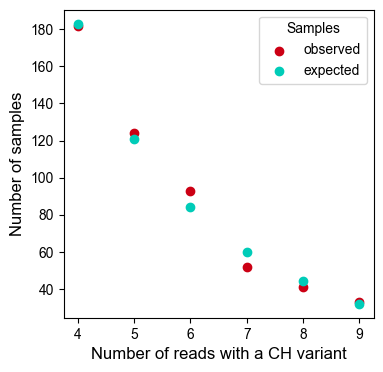

In [223]:

# merge the dataframe to compare observation and expectation
exp_obs = pd.merge(observed_counts_df, expected_counts_df, on = 'read number')
exp_obs['difference'] = exp_obs['observed read count'] - exp_obs['expected read count']
exp_obs['difference**2'] = exp_obs['difference']**2

# plot 
plt.figure(figsize = (4,4))
plt.scatter(exp_obs['read number'], exp_obs['observed read count'], label = 'observed', color = '#b34800')
plt.scatter(exp_obs['read number'], exp_obs['expected read count'], label = 'expected', color = '#006bb3')
plt.legend(fontsize = 11)
plt.xlabel('Number of reads with a CH variant', fontsize = 12)
plt.ylabel('Number of samples',  fontsize = 12)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xticks([4,5,6,7,8,9])
legend = plt.legend()
legend.set_title('Samples')
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_fitting_var_depth_4.pdf', bbox_inches='tight')


# Extend to 1-11 reads

In [195]:

# okay do this again for all 1-11
# obtain the expected number of people with a given number of reads 
expected_counts1 = {}
for i in list(range(1,11)):
    expected_counts1[i] = int(prob_of_n_reads_across_all_VAFs(list_values, fitted , 70, i) * len(list_of_ppl_interrogated))

# now, this is our expectation for some set of parameters 
# we would like this to match the observed number 
expected_counts1
expected_counts1_df = pd.DataFrame(expected_counts1, index = ['read count']).T
expected_counts1_df = expected_counts1_df.reset_index()
expected_counts1_df.columns.values[0] = 'read number'
expected_counts1_df = expected_counts1_df.sort_values(by = 'read number')
expected_counts1_df = expected_counts1_df.rename(columns={'read count': 'expected read count'})


In [196]:

# Read all batches in the folder 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls_annotated'
list_of_var_depths1 = []
list_of_VAF1 = [] 

# we want to read this file again but now append all cases with reads (ie include singletons, 2x etc)
for filename in os.listdir(folder_path):

    if filename.endswith(".txt"):  # search for files in the folder with a tsv extension
        file_path = os.path.join(folder_path, filename)

        with open(file_path, 'r') as csvfile:
            read_reader = csv.DictReader(csvfile, delimiter="\t")  #csv.reader returns a reader object which will iterate over lines in the csvfile
            row_count=0
            
            vaf_id_dict = {}

            for row in read_reader:
        #         print((row.keys()))
                patient_id = row['sample_ID']
                VAF = row['VAF']
                total_depth = row['depth']
                var_depth = int(row['var_depth'])
                if var_depth >=1: # select only cases where there are at least 4 reads with the variant detected 
                    list_of_VAF1.append(VAF)
                    list_of_var_depths1.append(var_depth)

print('number of high VAF variants in analysis:', len(list_of_VAF1))

observed_counts1 = {}

for element in list_of_var_depths1:
    if element in observed_counts1:
        observed_counts1[element] += 1
    else:
        observed_counts1[element] = 1


observed_counts_df1 = pd.DataFrame(observed_counts1, index = ['read count']).T
observed_counts_df1 = observed_counts_df1.reset_index()
observed_counts_df1.columns.values[0] = 'read number'
observed_counts_df1 = observed_counts_df1.sort_values(by = 'read number')

observed_counts_df1_sub = observed_counts_df1[observed_counts_df1['read number'] < 10]
observed_counts_df1_sub


number of high VAF variants in analysis: 76718


,read number,read count
0,1,73895
1,2,1570
6,3,389
2,4,195
5,5,133
8,6,102
10,7,60
3,8,48
11,9,37


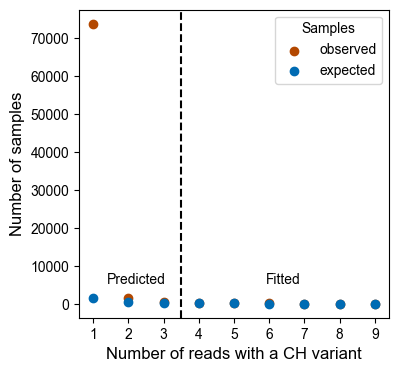

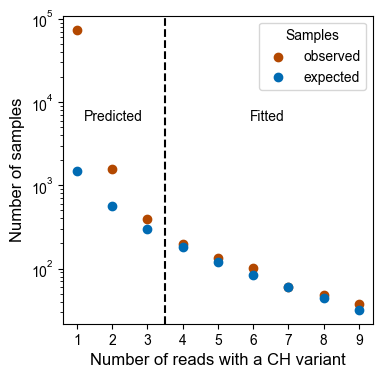

In [244]:

# merge the dataframe to compare observation and expectation
exp_obs1 = pd.merge(observed_counts_df1_sub, expected_counts1_df, on = 'read number')
exp_obs1['difference'] = exp_obs1['read count'] - exp_obs1['expected read count']
exp_obs1['difference**2'] = exp_obs1['difference']**2

# plot 
plt.figure(figsize = (4,4))
plt.scatter(exp_obs1['read number'], exp_obs1['read count'], label = 'observed', color = '#b34800')
plt.scatter(exp_obs1['read number'], exp_obs1['expected read count'], label = 'expected', color = '#006bb3')
plt.legend(fontsize = 11)
plt.xlabel('Number of reads with a CH variant', fontsize = 12)
plt.ylabel('Number of samples', fontsize = 12)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xticks([1,2,3,4,5,6,7,8,9])
legend = plt.legend()
legend.set_title('Samples')
plt.axvline(x=3.5, color='black', linestyle='--')
plt.text(1.4, 5400, 'Predicted', color='black', fontsize = 10)
plt.text(5.9, 5400, 'Fitted', color='black', fontsize = 10)
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_expected_vs_observed', bbox_inches='tight')

# plot 
plt.figure(figsize = (4,4))
plt.scatter(exp_obs1['read number'], exp_obs1['read count'], label = 'observed', color = '#b34800')
plt.scatter(exp_obs1['read number'], exp_obs1['expected read count'], label = 'expected', color = '#006bb3')
plt.legend(fontsize = 12)
plt.xlabel('Number of reads with a CH variant', fontsize = 12)
plt.ylabel('Number of samples', fontsize = 12)
plt.yscale('log')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xticks([1,2,3,4,5,6,7,8,9])
legend = plt.legend()
legend.set_title('Samples')
# add line to separate fitted and predicted
plt.axvline(x=3.5, color='black', linestyle='--')
plt.text(1.2, 6000, 'Predicted', color='black', fontsize = 10)
plt.text(5.9, 6000, 'Fitted', color='black', fontsize = 10)
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_expected_vs_observed_log_scale.pdf', bbox_inches='tight')


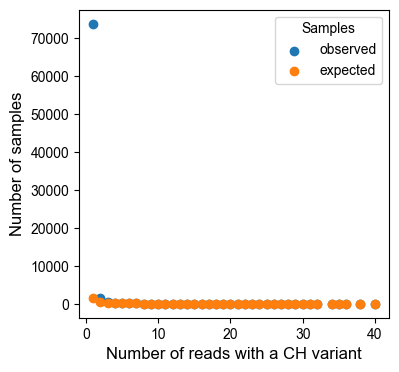

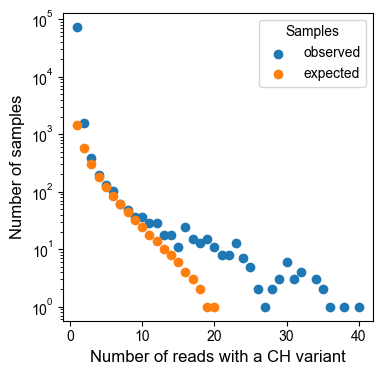

In [211]:

# can plot to see how good the fit is if you extend the data (max nr of observed reads = 44)

# obtain the expected number of people with a given number of reads 
expected_counts2 = {}
for i in list(range(1,44)):
    expected_counts2[i] = int(prob_of_n_reads_across_all_VAFs(list_values, fitted , 70, i) * len(list_of_ppl_interrogated))

# now, this is our expectation for some set of parameters 
# we would like this to match the observed number 
expected_counts2_df = pd.DataFrame(expected_counts2, index = ['read count']).T
expected_counts2_df = expected_counts2_df.reset_index()
expected_counts2_df.columns.values[0] = 'read number'
expected_counts2_df = expected_counts2_df.sort_values(by = 'read number')
expected_counts2_df = expected_counts2_df.rename(columns={'read count': 'expected read count'})

# merge the dataframe to compare observation and expectation
exp_obs2 = pd.merge(observed_counts_df1, expected_counts2_df, on = 'read number')
exp_obs2['difference'] = exp_obs2['read count'] - exp_obs2['expected read count']
exp_obs2['difference**2'] = exp_obs2['difference']**2

# plot
plt.figure(figsize = (4,4))
plt.scatter(exp_obs2['read number'], exp_obs2['read count'], label = 'observed')
plt.scatter(exp_obs2['read number'], exp_obs2['expected read count'], label = 'expected')
plt.legend(fontsize = 11)
plt.xlabel('Number of reads with a CH variant',fontsize = 12)
plt.ylabel('Number of samples',fontsize = 12)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
legend = plt.legend()
legend.set_title('Samples')
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_expected_vs_observed_to44.pdf', bbox_inches='tight')

plt.figure(figsize = (4,4))
plt.scatter(exp_obs2['read number'], exp_obs2['read count'], label = 'observed')
plt.scatter(exp_obs2['read number'], exp_obs2['expected read count'], label = 'expected')
plt.legend(fontsize = 11)
plt.xlabel('Number of reads with a CH variant', fontsize = 12)
plt.ylabel('Number of samples',fontsize = 12)
plt.yscale('log')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
legend = plt.legend()
legend.set_title('Samples')
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure1/{timestr}/{timestr}_expected_vs_observed_log_scale_to44.pdf', bbox_inches='tight')
